In [1]:
import sys
import os
import torch
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from models.enhanced_resnet import EnhancedResnet
import matplotlib.pyplot as plt
from torchvision import models
import torch
import cv2
from scipy.optimize import differential_evolution
import torch.nn as nn
from torch.autograd import Variable
from model import BasicCNN
from torchvision.utils import save_image
from PIL import Image
import random
from threading import Thread

In [2]:
def plot_figs(imgs):
    f = plt.figure(figsize=(8,4))
    plt.axis('off')
    tot = len(imgs)
    i=0
    pilTrans = transforms.ToPILImage()
    for img in imgs:
        i = i+1
        f.add_subplot(1,tot, i)
        plt.imshow(pilTrans(img))
    plt.show()
def preprocess(img):
    img = img.astype(np.float32)
    img /= 255.0
    img = img.transpose(2, 0, 1)
    return img
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()
def scale(x, scale=5):
    return cv2.resize(x, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
def perturb(x):
    adv_img = img.copy()
    pixs = np.array(np.split(x, len(x)/5)).astype(int)
    loc = (pixs[:, 0], pixs[:,1])
    val = pixs[:, 2:]
    adv_img[loc] = val
    return adv_img
def optimize(x):
    adv_img = perturb(x)
    inp = Variable(torch.from_numpy(preprocess(adv_img)).float().unsqueeze(0))
    out = model(inp)
    prob = softmax(out.data.numpy()[0])
    return prob[pred_orig]

In [3]:
tr = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())
pred_adv = 0
prob_adv = 0
def callback(x, convergence):
    global pred_adv, prob_adv
    adv_img = perturb(x)
    inp = Variable(torch.from_numpy(preprocess(adv_img)).float().unsqueeze(0))
    out = model(inp)
    prob = softmax(out.data.numpy()[0])
    pred_adv = np.argmax(prob)
    prob_adv = prob[pred_adv]
    if pred_adv != pred_orig and prob_adv >= 0.9:
        print('Attack successful..')
        print('Prob [%s]: %f' %(cifar10_class_names[pred_adv], prob_adv))
        print()
        return True
    else:
        print('Prob [%s]: %f' %(cifar10_class_names[pred_orig], prob[pred_orig]))

Files already downloaded and verified


In [4]:
idx = 318
fname = "images/adv_img_"+str(idx)+".png"
d = 1
iters = 600
popsize = 10

In [5]:
tnsr,lb = tr.__getitem__(idx)
save_image(tnsr,"images/testing.png")
image_path = "images/testing.png" #images/airplane.png or car.png adv-3.png adv-37.png adv-158.png 221.png
cifar10_class_names = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [6]:
orig = cv2.imread(image_path)[..., ::-1]
orig = cv2.resize(orig, (32, 32))
img = orig.copy()
shape = orig.shape
model = BasicCNN()
saved = torch.load("saved/cifar10_basiccnn.pth.tar")
model.load_state_dict(saved['state_dict'])
model.eval()
inp = Variable(torch.from_numpy(preprocess(img)).float().unsqueeze(0))
prob_orig = softmax(model(inp).data.numpy()[0])
pred_orig = np.argmax(prob_orig)
print('Prediction before attack: %s' %(cifar10_class_names[pred_orig]))
print('Probability: %f' %(prob_orig[pred_orig]))

Prediction before attack: dog
Probability: 0.896191


In [7]:
def predictimg(img):
    tnsr = transforms.ToTensor()
    i = random.randint(1,3)
    if i==1:
        print("Vertical transformation applied.")
        img = transforms.functional.vflip(img)
    elif i==2:
        print("Horizontal flip applied.")
        img = transforms.functional.hflip(img)
    else:
        ang = {1:30,2:45,3:60,4:120,5:135,6:225}
        j = random.randint(1,6)
        print("Imgae rotation with %d degrees applied."%(ang[j]))
        img = transforms.functional.rotate(img,angle=ang[j]) 
    t = tnsr(img)
    inp = Variable(t).float().unsqueeze(0)
    out = model(inp)
    prob = softmax(out.data.numpy()[0])
    n = cifar10_class_names[np.argmax(prob)]
    v = np.amax(prob)
    print('Prediction of the image after attack: %s' %(n))
    print('Confidence: %f' %(v))
    return n,t

In [8]:
def predictimglive(img):
    #tnsr = transforms.ToTensor()
    i = random.randint(1,3)
    if i==1:
        print("Vertical Applied:")
        img = transforms.functional.vflip(img)
    elif i==2:
        print("Horizontal flip applied:")
        img = transforms.functional.hflip(img)
    else:
        ang = {1:30,2:45,3:60,4:120,5:135,6:225}
        j = random.randint(1,6)
        print("Imgae rotation with %d degrees applied:"%(ang[j]))
        img = transforms.functional.rotate(img,angle=ang[j]) 
    #t = tnsr(img)
    inp = Variable(img).float().unsqueeze(0)
    out = model(inp)
    prob = softmax(out.data.numpy()[0])
    n = cifar10_class_names[np.argmax(prob)]
    #v = np.amax(prob)
    #print('Prediction of the image after attack: %s' %(n))
    #print('Confidence: %f' %(v))
    return n

In [9]:
bounds = [(0, shape[0]-1), (0, shape[1]), (0, 255), (0, 255), (0, 255)] * d
result = differential_evolution(optimize, bounds, maxiter=iters, popsize=popsize, tol=1e-5, callback=callback)
adv_img = perturb(result.x)
inp = Variable(torch.from_numpy(preprocess(adv_img)).float().unsqueeze(0))
out = model(inp)
prob = softmax(out.data.numpy()[0])
print('Prob [%s]: %f --> Prob[%s]: %f' %(cifar10_class_names[pred_orig], prob_orig[pred_orig], cifar10_class_names[pred_adv], prob_adv))

Prob [dog]: 0.643075
Prob [dog]: 0.643075
Prob [dog]: 0.643075
Prob [dog]: 0.643075
Prob [dog]: 0.643075
Prob [dog]: 0.633599
Prob [dog]: 0.633599
Prob [dog]: 0.509659
Prob [dog]: 0.489746
Prob [dog]: 0.474802
Prob [dog]: 0.474802
Prob [dog]: 0.453764
Prob [dog]: 0.453764
Prob [dog]: 0.453764
Prob [dog]: 0.449816
Prob [dog]: 0.449816
Prob [dog]: 0.449816
Prob [dog]: 0.449816
Prob [dog]: 0.449816
Prob [dog]: 0.444786
Prob [dog]: 0.444786
Prob [dog]: 0.444786
Prob [dog]: 0.444786
Prob [dog]: 0.444486
Prob [dog]: 0.444486
Prob [dog]: 0.443094
Prob [dog]: 0.442851
Prob [dog]: 0.442851
Prob [dog]: 0.442355
Prob [dog]: 0.442355
Prob [dog]: 0.442355
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0.441781
Prob [dog]: 0

C:\Anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:603: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


Prob [dog]: 0.441781
Prob [dog]: 0.896191 --> Prob[frog]: 0.451300


In [59]:
cv2.imwrite(fname, adv_img[..., ::-1]) #images/adv_img_airplane.png
cv2.imshow('adversarial image', scale(adv_img[..., ::-1]))
while True:
    key = cv2.waitKey(33)
    if key == 27 or key == 32:
        cv2.destroyAllWindows()
        break

In [74]:
print("Prediction of adevrserial image with random data augmentation:")
print('Prediction before attack: %s' %(cifar10_class_names[pred_orig]))
print('Probability: %f' %(prob_orig[pred_orig]))
im = Image.open(fname)
n,t= predictimg(im)

Prediction of adevrserial image with random data augmentation:
Prediction before attack: dog
Probability: 0.896191
Horizontal flip applied.
Prediction of the image after attack: frog
Confidence: 0.590027


C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


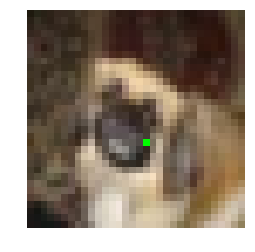

In [75]:
plot_figs([t])

In [9]:
class VideoStream:
    def __init__(self, src=0):
        self.stream = cv2.VideoCapture(src)
        self.stream.open('http://192.168.0.33:4747/video')
        (self.grabbed, self.frame) = self.stream.read()
        self.stopped = False

    def start(self):
        Thread(target=self.update, args=()).start()
        return self

    def update(self):
        while True:
            if self.stopped:
                return
            (self.grabbed, self.frame) = self.stream.read()

    def read(self):
        # Return the latest frame
        return self.frame

    def stop(self):
        self.stopped = True

In [13]:
frame_count = 0
score = 0
pred = 0
last = 0
human_string = None
vs = VideoStream(src=1).start()

# Model

In [ ]:
n = "NONE"
l=0
while True:
    frame = vs.read()
    frame_count += 1
    cv2.putText(frame, "*", (160, 110),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.putText(frame, "*", (160, 410),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.putText(frame, "*", (460, 110),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.putText(frame, "*", (460, 410),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    #frame = frame[40:160,40:160] #y1y2x1x2
    if frame_count % 15 == 0:
        img = frame[110:410,160:460] #y1y2x1x2
        img = img[..., ::-1]
        img = cv2.resize(img, (32, 32))
        inp = Variable(torch.from_numpy(preprocess(img)).float().unsqueeze(0)) #
        out = model(inp) #
        prob = softmax(out.data.numpy()[0])
        n = cifar10_class_names[np.argmax(prob)]
        #l = int(len(n)/2)
                           
    cv2.putText(frame, n, (280, 430),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break

vs.stop()   
print("Done")

# Model with Data Augmentation

In [11]:
n = "NONE"
pilTrans = transforms.ToPILImage()
tnsr = transforms.ToTensor()
while True:
    frame = vs.read()
    frame_count +=1
    cv2.putText(frame, "*", (160, 110),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.putText(frame, "*", (160, 410),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.putText(frame, "*", (460, 110),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.putText(frame, "*", (460, 410),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    if frame_count % 200 == 0:
        img = frame[110:410,160:460]
        img = img[..., ::-1]
        img = cv2.resize(img,(32,32))
        im = pilTrans(torch.from_numpy(preprocess(img)))
        im = transforms.functional.hflip(im)
        inp = Variable(tnsr(im)).float().unsqueeze(0)
        out = model(inp)
        prob = softmax(out.data.numpy()[0])
        n = cifar10_class_names[np.argmax(prob)]
    cv2.putText(frame, n, (280, 430),cv2.FONT_HERSHEY_TRIPLEX, 1, (255, 255, 255))
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        cv2.destroyAllWindows()
        break
vs.stop()



In [21]:
vs.stop()

In [10]:
int(4/2)

2